In [ ]:
:orphan:

# SPIE Optics + Photonics Figures

This notebook contains the code used to re-produce the figures in our SPIE Proceedings.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.polynomials import noll_to_nm, zernike_nm_sequence, sum_of_2d_modes
from prysm.geometry import circle

from katsu.mueller import (
    linear_diattenuator,
    linear_retarder,
    linear_polarizer
)

from katsu.katsu_math import np, set_backend_to_jax
import numpy as tnp

# Plotting stuff

plt.style.use('bmh')
okabe_colorblind8 = [
'#E69F00',
'#56B4E9',
'#009E73',
'#F0E442',
'#0072B2',
'#D55E00',
'#CC79A7',
'#000000',
]
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe_colorblind8)


def plot_square(x,n=4,vmin=None,vmax=None):
    """A simple plotting macro for viewing intermediate results
    """
    k = 1
    plt.figure(figsize=[10,10])
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax, cmap='RdBu_r')
            plt.colorbar()
            k += 1
    plt.show()


def jax_sum_of_2d_modes(modes, weights):
    """a clone of prysm.polynomials sum_of_2d_modes that works when using katsu's Jax backend

    Parameters
    ----------
    modes : list of ndarrays
        list of polynomials constituting the desired basis
    weights : list of floats
        coefficients that describe the presence of each mode in the modes list

    Returns
    -------
    ndarray
        2D ndarray containing the sum of weighted modes
    """
    modes = np.asarray(modes)
    weights = np.asarray(weights).astype(modes.dtype)

    # dot product of the 0th dim of modes and weights => weighted sum
    return np.tensordot(modes, weights, axes=(0, 0))

def sum_of_2d_modes_wrapper(modes, weights):
    """ Wrapper that lets us ignore which source module we want to use
    """
    if np._srcmodule == tnp:
        return sum_of_2d_modes(modes, weights)
    else:
        return jax_sum_of_2d_modes(modes, weights)

We begin by initializing a polynomial basis using the `prysm` optical propagation tool, which contains highly efficient routines for generating various polynomials. In this study, we elect to use the Zernike polynomial basis due to their orthonormality enabling more efficient optimization, but this is simply an illustrative choice that is not grounded in the physics that give rise to nonuniformities in retarders. Any choice of basis is likely sufficient, and the user should use one that is appropriate for their use case.

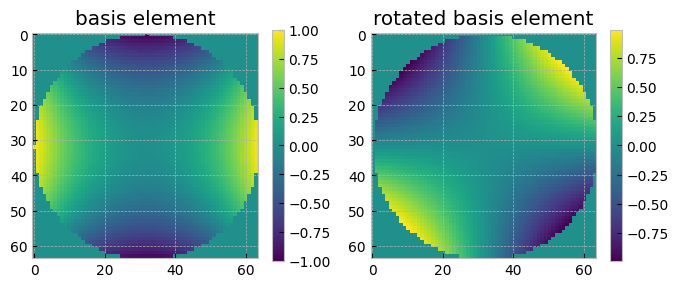

In [2]:
NPIX = 64
NMODES = 128
NMEAS = 24


x, y = make_xy_grid(NPIX, diameter=2)
r, t = cart_to_polar(x, y)

def construct_zern_basis(r, t):

    nms = [noll_to_nm(i) for i in range(1, NMODES)]

    # Norm = False is required to have unit peak-to-valley
    basis_full = list(zernike_nm_sequence(nms, r, t, norm=False))
    A = circle(1, r) # a circular mask to apply to the beam
    basis = [mode * A for mode in basis_full ]

    return basis

A = circle(1, r)
basis = construct_zern_basis(r, t)
basis_rotated = construct_zern_basis(r, t + np.pi / 4)
plt.figure(figsize=[8,3])
plt.subplot(121)
plt.title("basis element")
plt.imshow(basis[5])
plt.colorbar()
plt.subplot(122)
plt.title("rotated basis element")
plt.imshow(basis_rotated[5])
plt.colorbar()
plt.show()

We next define a forward model that generally supports spatially-varying retarders that can rotate.

In [3]:
def rotation_matrix(th):
    return np.array([[np.cos(th), -np.sin(th)],
                     [np.sin(th), np.cos(th)]])

def forward_simulate(x):

    ROTATION_RATIO = 2.5
    END_ANGLE_PSG = 180

    # unpack the parameters
    theta_pg = x[0] # Starting angle of the polarizer
    theta_pa = x[1] # Starting angle of the polarizer

    # get spatially varying coefficcients
    coeffs_spatial_ret_psg = x[2 : 2 + 1*len(basis)]
    coeffs_spatial_ang_psg = x[2 + 1*len(basis):(2 + 2*len(basis))]
    coeffs_spatial_ret_psa = x[2 + 2*len(basis):(2 + 3*len(basis))]
    coeffs_spatial_ang_psa = x[2 + 3*len(basis):(2 + 4*len(basis))]

    # set up the basis with rotation
    x, y = make_xy_grid(NPIX, diameter=2)
    r, t = cart_to_polar(x, y)

    # the nominal rotations performed
    rotations_psg = np.linspace(0, np.radians(END_ANGLE_PSG), NMEAS)
    rotations_psa = rotations_psg * ROTATION_RATIO

    psg_retardances, psa_retardances = [], []
    psg_fast_axes, psa_fast_axes = [], []

    for rot_psg, rot_psa in zip(rotations_psg, rotations_psa):

        # Get the rotated spatial basis
        basis_psg = np.asarray(construct_zern_basis(r, t + rot_psg))
        basis_psa = np.asarray(construct_zern_basis(r, t + rot_psa))

        # compute retardances
        psg_retardance = sum_of_2d_modes_wrapper(basis_psg, coeffs_spatial_ret_psg)
        psa_retardance = sum_of_2d_modes_wrapper(basis_psa, coeffs_spatial_ret_psa)

        # compute fast axes
        psg_fast_axis = sum_of_2d_modes_wrapper(basis_psg, coeffs_spatial_ang_psg)
        psa_fast_axis = sum_of_2d_modes_wrapper(basis_psa, coeffs_spatial_ang_psa)

        # store arrays in list
        psg_retardances.append(psg_retardance)
        psa_retardances.append(psa_retardance)
        psg_fast_axes.append(psg_fast_axis)
        psa_fast_axes.append(psa_fast_axis)

    # get lists as arrays
    psg_retardances = np.asarray(psg_retardances)
    psa_retardances = np.asarray(psa_retardances)
    psg_fast_axes = np.asarray(psg_fast_axes) + rotations_psg[..., None, None]
    psa_fast_axes = np.asarray(psa_fast_axes) + rotations_psa[..., None, None]

    # swap axes around
    psg_retardances = np.moveaxis(psg_retardances, 0, -1)
    psa_retardances = np.moveaxis(psa_retardances, 0, -1)
    psg_fast_axes = np.moveaxis(psg_fast_axes, 0, -1)
    psa_fast_axes = np.moveaxis(psa_fast_axes, 0, -1)

    # set up the drrp
    psg_pol = linear_polarizer(theta_pg, shape=[NMEAS])
    psg_wvp = linear_retarder(psg_fast_axes, psg_retardances, shape=[NPIX, NPIX, NMEAS])

    psa_wvp = linear_retarder(psa_fast_axes, psa_retardances, shape=[NPIX, NPIX, NMEAS])
    psa_pol = linear_polarizer(theta_pa, shape=[NMEAS])

    # Create power measurements
    power_measured = (psa_pol @ psa_wvp @ psg_wvp @ psg_pol)[..., 0, 0]

    return power_measured

The next step is to define our ground truth parameters.

In [4]:
# ground truth
SCALE = 100
theta_pg = np.radians(0)
theta_pa = np.radians(0)

# Init retardance, PSG
coeffs_spatial_ret_psg = tnp.random.random(len(basis)) / SCALE
coeffs_spatial_ret_psg[0] = np.pi / 2

# Init angle, PSG
coeffs_spatial_ang_psg = tnp.random.random(len(basis)) / SCALE**2
coeffs_spatial_ang_psg[0] = tnp.random.random()

# Init retardance, PSA
coeffs_spatial_ret_psa = tnp.random.random(len(basis)) / SCALE
coeffs_spatial_ret_psa[0] = np.pi / 2

# Init angle, PSA
coeffs_spatial_ang_psa = tnp.random.random(len(basis)) / SCALE**2
coeffs_spatial_ang_psa[0] = np.random.random()

x0_truth = np.concatenate([np.array([theta_pg, theta_pa]), coeffs_spatial_ret_psg, coeffs_spatial_ang_psg, coeffs_spatial_ret_psa, coeffs_spatial_ang_psa])
power_experiment = forward_simulate(x0_truth)

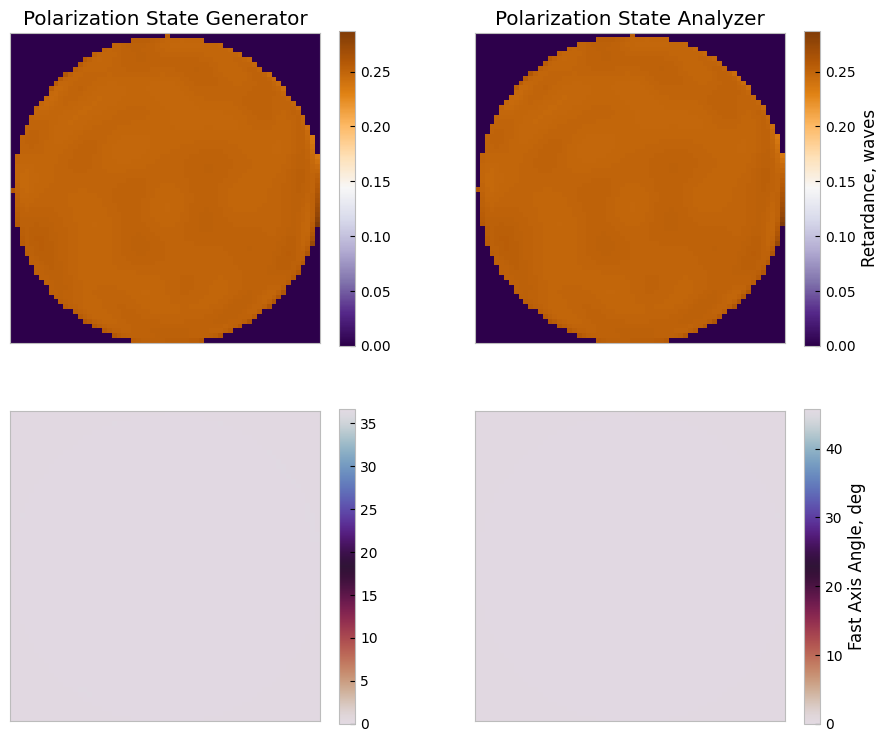

In [5]:
# plot the ground truth retardance and angles
retardance_psg = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ret_psg)
retardance_psa = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ret_psa)
angle_psg = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ang_psg)
angle_psa = sum_of_2d_modes_wrapper(basis, coeffs_spatial_ang_psa)

plt.figure(figsize=[11,9])
plt.subplot(221)
plt.title("Polarization State Generator")
plt.imshow(retardance_psg / (2 * np.pi), cmap="PuOr_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(222)
plt.title("Polarization State Analyzer")
plt.imshow(retardance_psg / (2 * np.pi), cmap="PuOr_r")
plt.colorbar(label="Retardance, waves")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(223)
plt.imshow(np.degrees(angle_psg), cmap="twilight_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(224)
plt.imshow(np.degrees(angle_psa), cmap="twilight_r")
plt.colorbar(label="Fast Axis Angle, deg")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

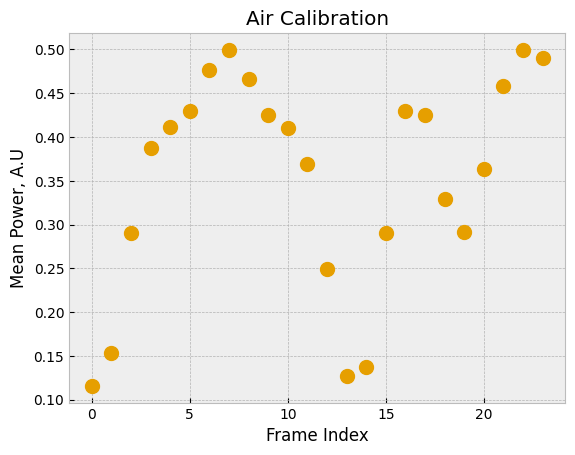

In [6]:
mean_power = []
for i in range(NMEAS):
    frame = power_experiment[..., i]
    mean_power.append(np.mean(frame[np.isfinite(frame)]))
    
plt.figure()
plt.plot(mean_power, marker="o", linestyle="None", markersize=10)
plt.ylabel("Mean Power, A.U")
plt.xlabel("Frame Index")
plt.title("Air Calibration")
plt.show()

Now we would originally fit to the angles that best represent these data points. But we aim to measure the spatially-varying coefficients. So, we set up an optimization problem in Python to fit to these data frame-by-frame.

On an M1 macbook pro, this takes like 3.25mins for 10 iterations, 10mins for 25 iterations

In [7]:
from scipy.optimize import minimize
from tqdm import tqdm

MAX_ITERS = 25

# Init some guess parameters
theta_pg = tnp.random.random()
theta_pa = tnp.random.random()

# Init retardance, PSG
coeffs_spatial_ret_psg = np.zeros(len(basis))
coeffs_spatial_ret_psg[0] = np.pi / 2

# Init angle, PSG
coeffs_spatial_ang_psg = (np.zeros(len(basis)))

# Init retardance, PSA
coeffs_spatial_ret_psa = np.zeros(len(basis))
coeffs_spatial_ret_psa[0] = np.pi / 2

# Init angle, PSA
coeffs_spatial_ang_psa = np.zeros(len(basis))

x0 = np.concatenate([np.array([theta_pg, theta_pa]), coeffs_spatial_ret_psg, coeffs_spatial_ang_psg, coeffs_spatial_ret_psa, coeffs_spatial_ang_psa])

# simple MSE loss function
def loss(x):
    diff = forward_simulate(x) - power_experiment
    diffsq = diff**2
    return np.sum(diffsq[A==1])

def callback(xk):
    pbar.update(1)

with tqdm(total=MAX_ITERS) as pbar:
    results = minimize(loss, x0=x0, callback=callback, method="L-BFGS-B", jac=False,
                       options={"maxiter": MAX_ITERS, "disp":True})

  0%|          | 0/25 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          510     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23047D+03    |proj g|=  8.18400D+03


 This problem is unconstrained.
  4%|▍         | 1/25 [04:30<1:48:09, 270.38s/it]


At iterate    1    f=  3.19171D+03    |proj g|=  7.60919D+03


  8%|▊         | 2/25 [06:45<1:13:02, 190.52s/it]


At iterate    2    f=  1.33655D+02    |proj g|=  1.56073D+03


 12%|█▏        | 3/25 [09:00<1:00:41, 165.50s/it]


At iterate    3    f=  6.79789D+01    |proj g|=  1.08419D+03


 16%|█▌        | 4/25 [11:16<53:48, 153.75s/it]  


At iterate    4    f=  2.03100D+01    |proj g|=  1.72919D+02


 20%|██        | 5/25 [13:33<49:15, 147.77s/it]


At iterate    5    f=  1.72907D+01    |proj g|=  1.30529D+02


 24%|██▍       | 6/25 [15:51<45:41, 144.29s/it]


At iterate    6    f=  3.25959D+00    |proj g|=  1.98097D+02


 28%|██▊       | 7/25 [20:24<55:59, 186.62s/it]


At iterate    7    f=  2.04450D+00    |proj g|=  9.53627D+01


 32%|███▏      | 8/25 [22:41<48:24, 170.84s/it]


At iterate    8    f=  1.53602D+00    |proj g|=  5.12061D+01


 36%|███▌      | 9/25 [24:55<42:28, 159.29s/it]


At iterate    9    f=  1.10589D+00    |proj g|=  4.69397D+01


 40%|████      | 10/25 [27:07<37:42, 150.86s/it]


At iterate   10    f=  6.77684D-01    |proj g|=  4.94846D+01


 44%|████▍     | 11/25 [29:23<34:08, 146.29s/it]


At iterate   11    f=  2.95906D-01    |proj g|=  2.55157D+01


 48%|████▊     | 12/25 [31:43<31:14, 144.17s/it]


At iterate   12    f=  2.24326D-01    |proj g|=  7.07801D+00


 52%|█████▏    | 13/25 [34:00<28:26, 142.23s/it]


At iterate   13    f=  2.10266D-01    |proj g|=  6.49684D+00


 56%|█████▌    | 14/25 [36:17<25:45, 140.49s/it]


At iterate   14    f=  1.98211D-01    |proj g|=  9.77108D+00


 60%|██████    | 15/25 [38:35<23:17, 139.73s/it]


At iterate   15    f=  1.75605D-01    |proj g|=  1.28193D+01


 64%|██████▍   | 16/25 [40:49<20:43, 138.15s/it]


At iterate   16    f=  1.48251D-01    |proj g|=  7.44641D+00


 68%|██████▊   | 17/25 [43:07<18:24, 138.12s/it]


At iterate   17    f=  1.27074D-01    |proj g|=  4.18487D+00


 72%|███████▏  | 18/25 [45:26<16:08, 138.29s/it]


At iterate   18    f=  1.14646D-01    |proj g|=  8.22319D+00


 76%|███████▌  | 19/25 [47:44<13:48, 138.14s/it]


At iterate   19    f=  9.72750D-02    |proj g|=  1.35704D+01


 80%|████████  | 20/25 [50:01<11:29, 137.92s/it]


At iterate   20    f=  7.54881D-02    |proj g|=  1.31271D+01


 84%|████████▍ | 21/25 [54:33<11:52, 178.12s/it]


At iterate   21    f=  7.18243D-02    |proj g|=  1.58057D+01


 88%|████████▊ | 22/25 [56:48<08:15, 165.29s/it]


At iterate   22    f=  5.88983D-02    |proj g|=  6.57490D+00


 92%|█████████▏| 23/25 [59:10<05:16, 158.27s/it]


At iterate   23    f=  5.43198D-02    |proj g|=  2.04533D+00


 96%|█████████▌| 24/25 [1:01:27<02:31, 151.76s/it]


At iterate   24    f=  5.15300D-02    |proj g|=  3.87140D+00


100%|██████████| 25/25 [1:03:44<00:00, 152.98s/it]


At iterate   25    f=  4.73647D-02    |proj g|=  5.57703D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  510     25     28      1     0     0   5.577D+00   4.736D-02
  F =   4.7364743193699536E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


And now we let L-BFGS-B do it's thing, to get an understanding of how we did, let's superimpose the modeled power with the measured power

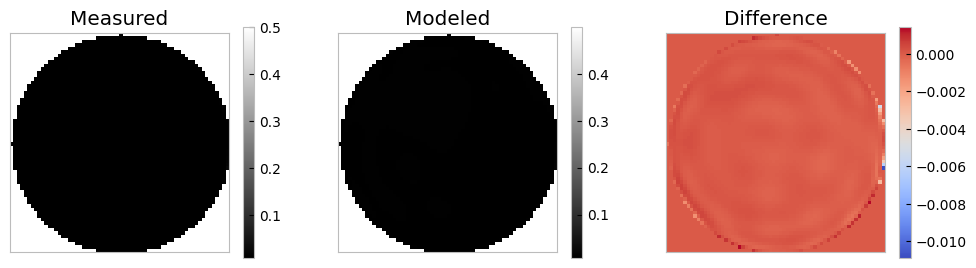

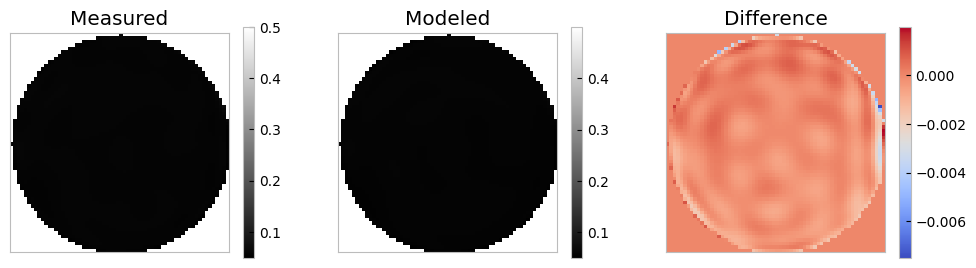

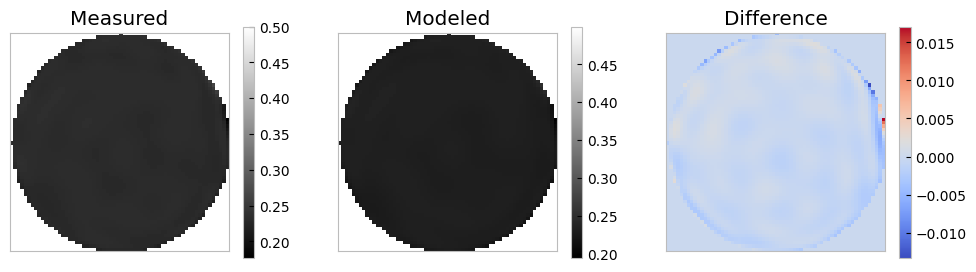

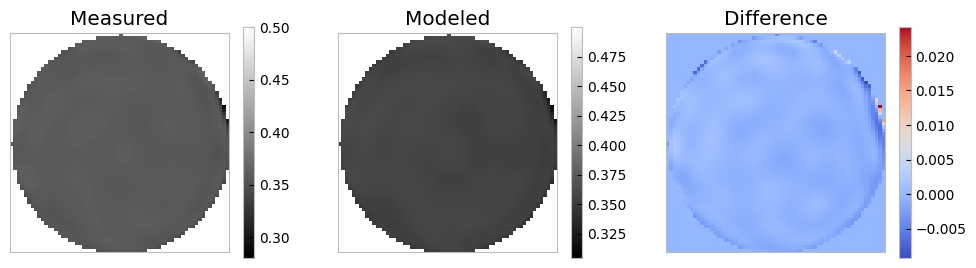

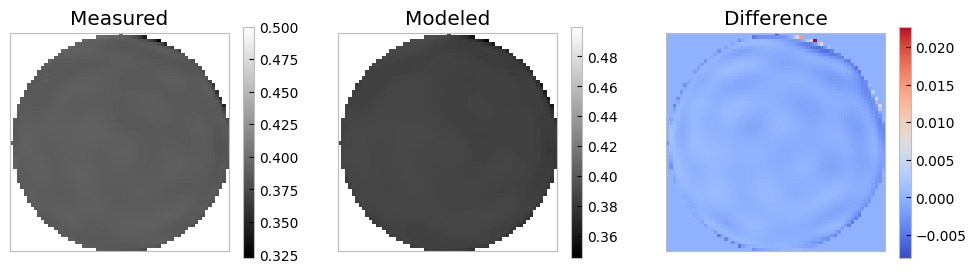

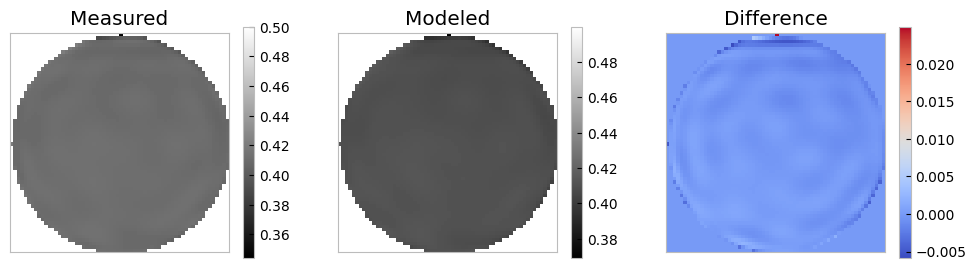

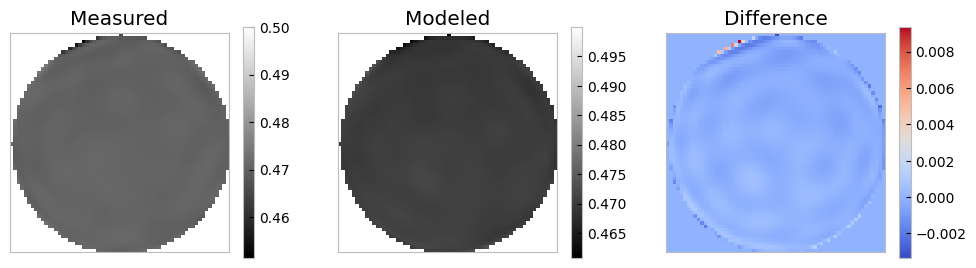

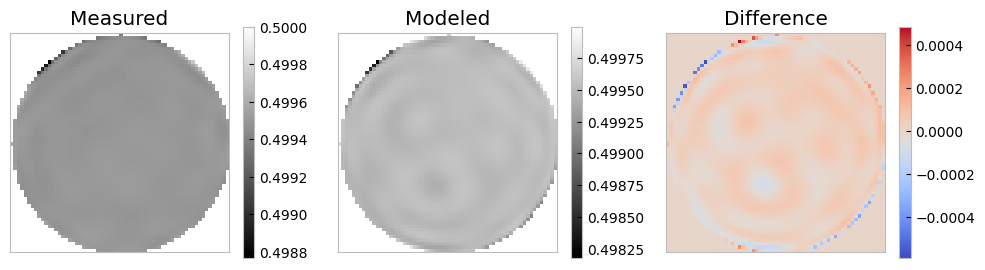

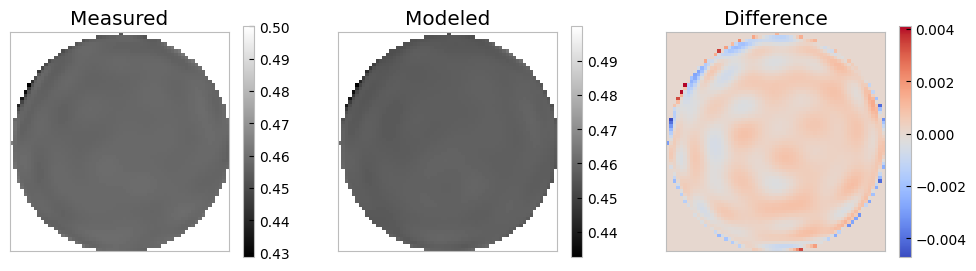

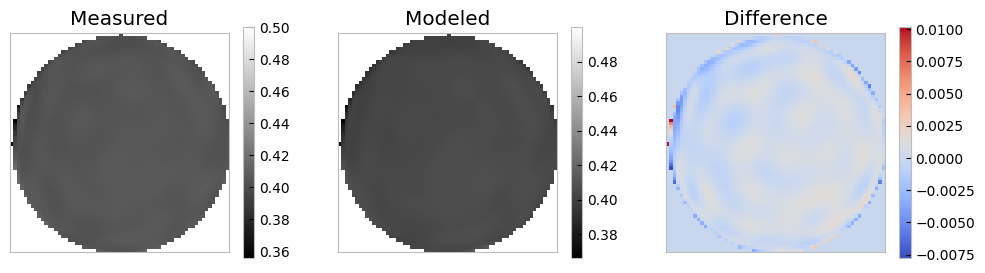

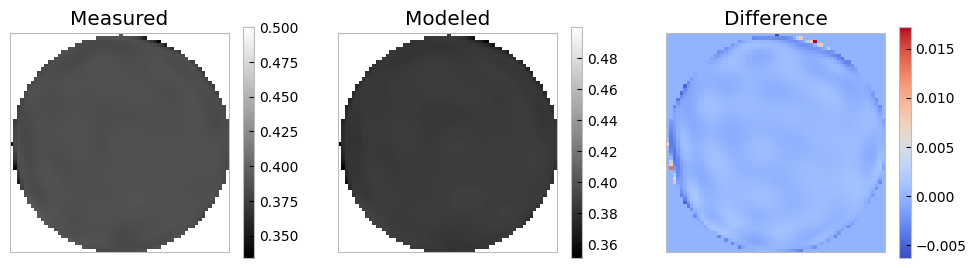

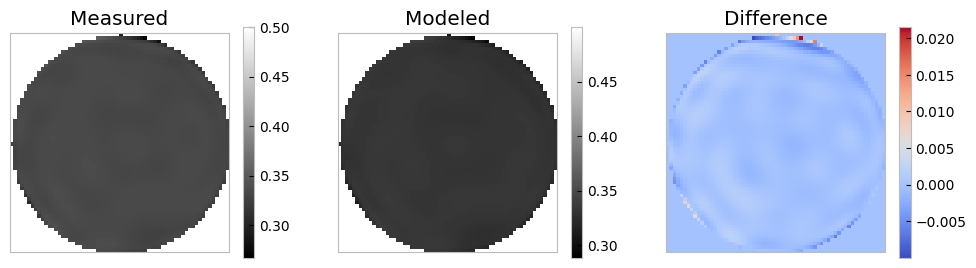

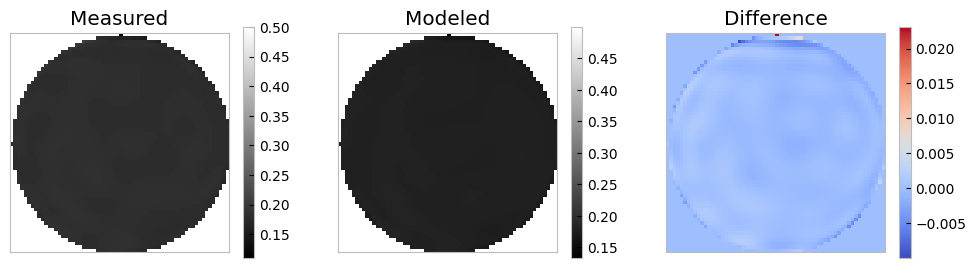

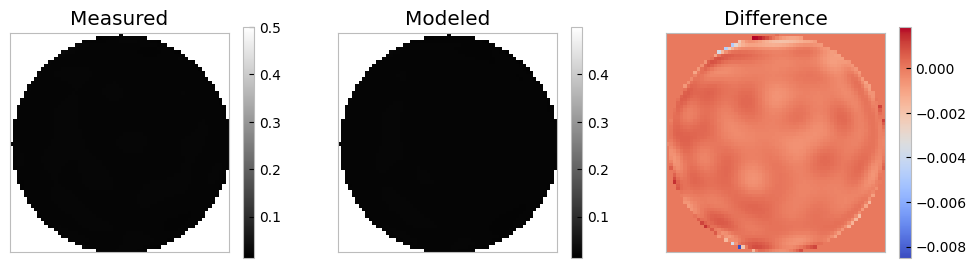

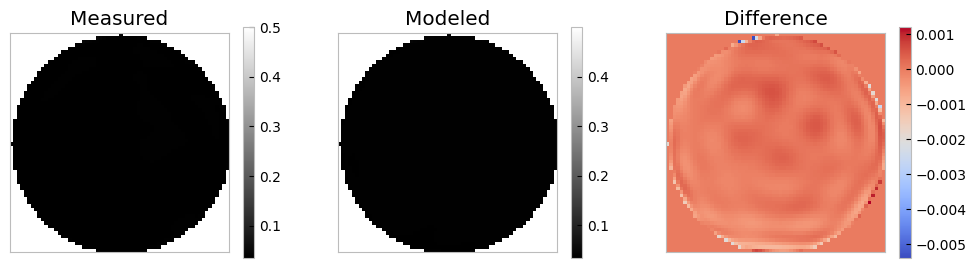

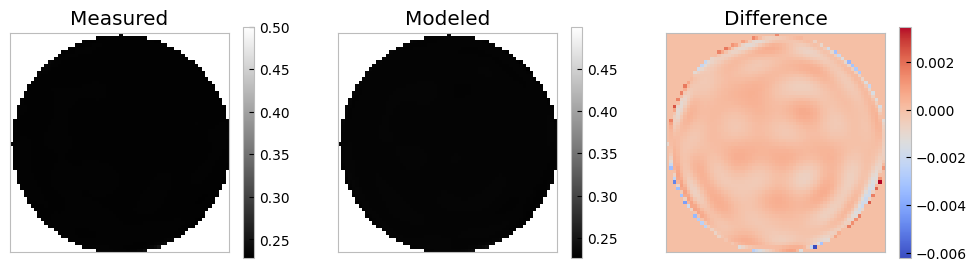

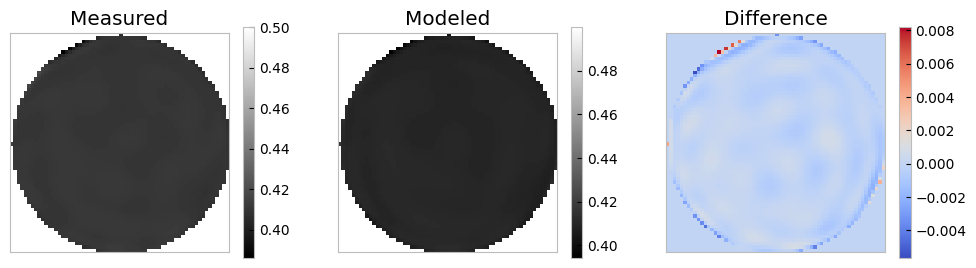

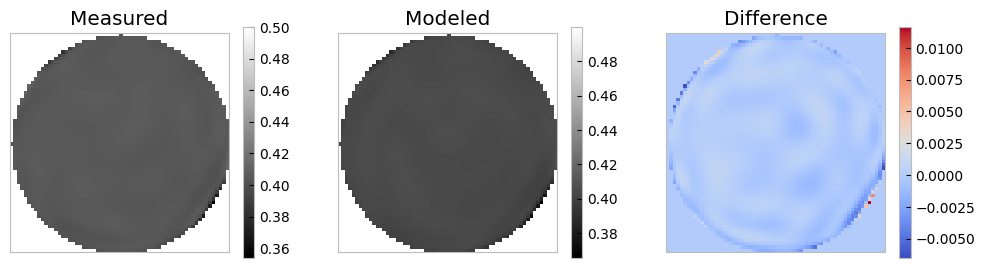

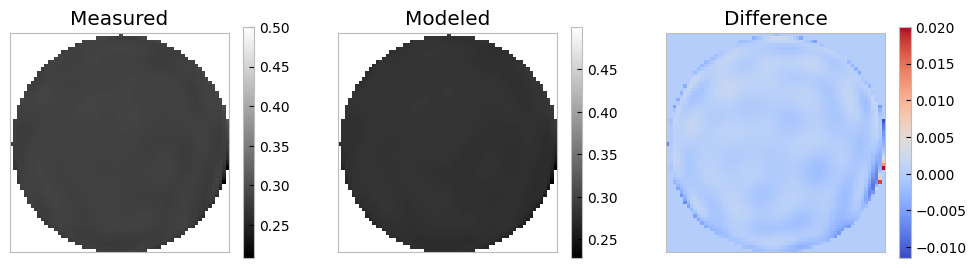

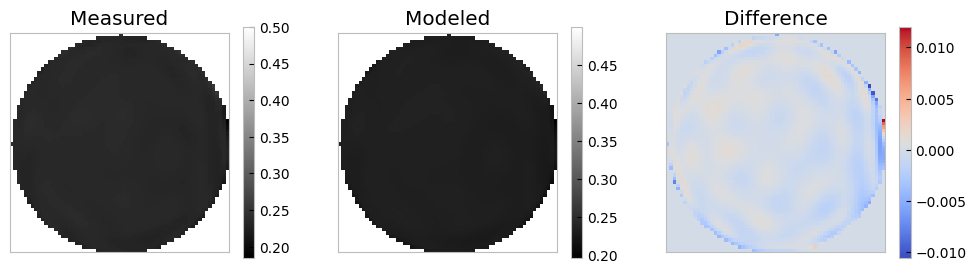

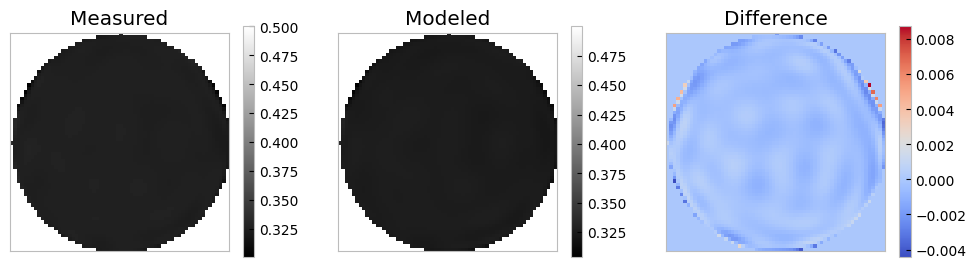

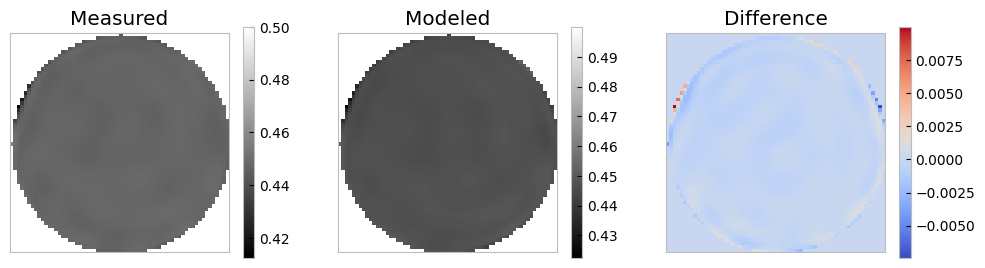

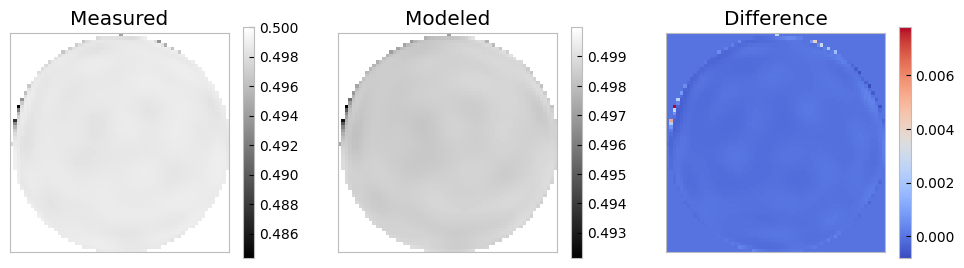

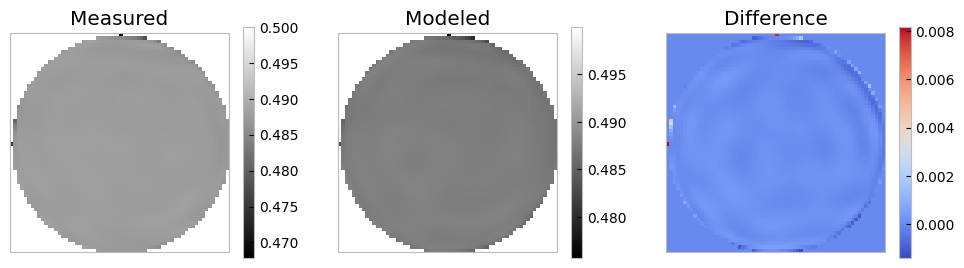

In [8]:
power_modeled = forward_simulate(results.x)

for i in range(NMEAS):

    pe = power_experiment[..., i]
    pm = power_modeled[..., i]

    plt.figure(figsize=[12,3])
    plt.subplot(131)
    plt.imshow(pe, cmap="gray")
    plt.colorbar()
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title("Measured")
    plt.subplot(132)
    plt.imshow(pm, cmap="gray")
    plt.colorbar()
    plt.title("Modeled")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.subplot(133)
    plt.imshow(pm - pe, cmap="coolwarm")
    plt.colorbar()
    plt.title("Difference")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.show()

In [9]:
from matplotlib.animation import FuncAnimation, ArtistAnimation

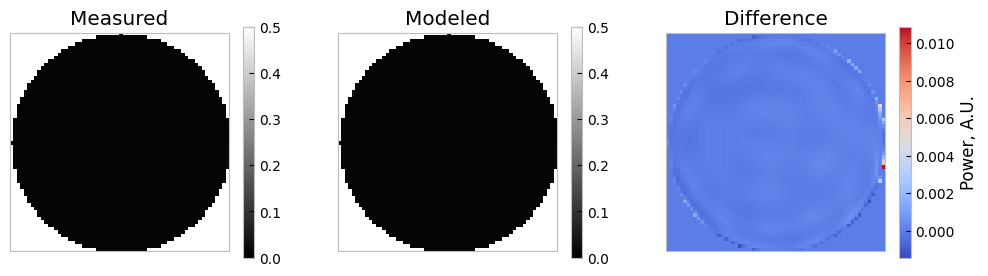

In [10]:
pe = power_experiment[..., 0]
pm = power_modeled[..., 0]

fig = plt.figure(figsize=[12,3])
plt.subplot(131)
im1 = plt.imshow(pe, cmap="gray", vmin=0, vmax=0.5)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.title("Measured")
plt.subplot(132)
im2 = plt.imshow(pm, cmap="gray", vmin=0, vmax=0.5)
plt.colorbar()
plt.title("Modeled")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(133)
im3 = plt.imshow(pe - pm, cmap="coolwarm")
plt.colorbar(label="Power, A.U.")
plt.title("Difference")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

def update(i):

    pe = power_experiment[..., i]
    pm = power_modeled[..., i]
    diff = pe - pm

    im1.set_data(pe)
    im2.set_data(pm)
    im3.set_data(diff)

    return [im1, im2, im3]

ani = FuncAnimation(fig, update, frames=range(NMEAS), blit=True, interval=1)



Now we employ the same experiment but this time we employ automatic differentiation

In [11]:
# ani.save("demo_video.gif")

In [12]:
set_backend_to_jax()

In [13]:
power_experiment_masked = np.copy(power_experiment)
power_experiment_masked = power_experiment_masked.at[np.isnan(power_experiment)].set(1e-10)

In [14]:
# need to define a new loss function
from jax import value_and_grad
def loss_jax(x):
    diff = forward_simulate(x) - power_experiment_masked
    diffsq = diff**2
    return np.sum(diffsq[A==1])

loss_fg = value_and_grad(loss_jax)

In [18]:
MAX_ITERS = 100

with tqdm(total=MAX_ITERS) as pbar:
    results_jax = minimize(loss_fg, x0=x0, callback=callback, method="L-BFGS-B", jac=True,
                       options={"maxiter": MAX_ITERS, "disp":True})

  0%|          | 0/100 [00:00<?, ?it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          510     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23047D+03    |proj g|=  8.18400D+03


  1%|          | 1/100 [00:02<04:33,  2.76s/it]


At iterate    1    f=  3.19171D+03    |proj g|=  7.60919D+03


  2%|▏         | 2/100 [00:04<03:15,  1.99s/it]


At iterate    2    f=  1.33655D+02    |proj g|=  1.56073D+03


  3%|▎         | 3/100 [00:05<02:50,  1.75s/it]


At iterate    3    f=  6.79789D+01    |proj g|=  1.08419D+03


  4%|▍         | 4/100 [00:06<02:22,  1.49s/it]


At iterate    4    f=  2.03100D+01    |proj g|=  1.72919D+02


  5%|▌         | 5/100 [00:07<02:10,  1.37s/it]


At iterate    5    f=  1.72907D+01    |proj g|=  1.30529D+02


  6%|▌         | 6/100 [00:09<01:59,  1.27s/it]


At iterate    6    f=  3.25959D+00    |proj g|=  1.98097D+02


  7%|▋         | 7/100 [00:11<02:27,  1.59s/it]


At iterate    7    f=  2.04450D+00    |proj g|=  9.53628D+01


  8%|▊         | 8/100 [00:12<02:11,  1.43s/it]


At iterate    8    f=  1.53602D+00    |proj g|=  5.12061D+01


  9%|▉         | 9/100 [00:13<02:01,  1.34s/it]


At iterate    9    f=  1.10589D+00    |proj g|=  4.69397D+01


 10%|█         | 10/100 [00:14<01:53,  1.26s/it]


At iterate   10    f=  6.77684D-01    |proj g|=  4.94846D+01


 11%|█         | 11/100 [00:15<01:48,  1.22s/it]


At iterate   11    f=  2.95906D-01    |proj g|=  2.55156D+01


 12%|█▏        | 12/100 [00:16<01:44,  1.19s/it]


At iterate   12    f=  2.24326D-01    |proj g|=  7.07801D+00


 13%|█▎        | 13/100 [00:17<01:40,  1.15s/it]


At iterate   13    f=  2.10266D-01    |proj g|=  6.49684D+00


 14%|█▍        | 14/100 [00:19<01:38,  1.14s/it]


At iterate   14    f=  1.98211D-01    |proj g|=  9.77116D+00


 15%|█▌        | 15/100 [00:20<01:35,  1.12s/it]


At iterate   15    f=  1.75605D-01    |proj g|=  1.28194D+01


 16%|█▌        | 16/100 [00:21<01:32,  1.11s/it]


At iterate   16    f=  1.48251D-01    |proj g|=  7.44649D+00


 17%|█▋        | 17/100 [00:22<01:32,  1.11s/it]


At iterate   17    f=  1.27074D-01    |proj g|=  4.18488D+00


 18%|█▊        | 18/100 [00:23<01:30,  1.10s/it]


At iterate   18    f=  1.14646D-01    |proj g|=  8.22313D+00


 19%|█▉        | 19/100 [00:24<01:30,  1.11s/it]


At iterate   19    f=  9.72749D-02    |proj g|=  1.35703D+01


 20%|██        | 20/100 [00:25<01:28,  1.10s/it]


At iterate   20    f=  7.54881D-02    |proj g|=  1.31272D+01


 21%|██        | 21/100 [00:27<01:55,  1.46s/it]


At iterate   21    f=  7.18242D-02    |proj g|=  1.58056D+01


 22%|██▏       | 22/100 [00:28<01:44,  1.34s/it]


At iterate   22    f=  5.88983D-02    |proj g|=  6.57478D+00


 23%|██▎       | 23/100 [00:30<01:38,  1.28s/it]


At iterate   23    f=  5.43198D-02    |proj g|=  2.04541D+00


 24%|██▍       | 24/100 [00:31<01:32,  1.22s/it]


At iterate   24    f=  5.15300D-02    |proj g|=  3.87148D+00


 25%|██▌       | 25/100 [00:32<01:28,  1.17s/it]


At iterate   25    f=  4.73648D-02    |proj g|=  5.57713D+00


 26%|██▌       | 26/100 [00:33<01:25,  1.16s/it]


At iterate   26    f=  3.84147D-02    |proj g|=  7.31140D+00


 27%|██▋       | 27/100 [00:34<01:22,  1.13s/it]


At iterate   27    f=  2.80660D-02    |proj g|=  5.28953D+00


 28%|██▊       | 28/100 [00:35<01:21,  1.13s/it]


At iterate   28    f=  2.27266D-02    |proj g|=  8.75775D+00


 29%|██▉       | 29/100 [00:36<01:19,  1.11s/it]


At iterate   29    f=  1.55074D-02    |proj g|=  2.38092D+00


 30%|███       | 30/100 [00:37<01:17,  1.10s/it]


At iterate   30    f=  1.41000D-02    |proj g|=  8.66076D-01


 31%|███       | 31/100 [00:38<01:17,  1.13s/it]


At iterate   31    f=  1.33316D-02    |proj g|=  1.88825D+00


 32%|███▏      | 32/100 [00:39<01:15,  1.12s/it]


At iterate   32    f=  1.20859D-02    |proj g|=  2.76510D+00


 33%|███▎      | 33/100 [00:41<01:14,  1.12s/it]


At iterate   33    f=  9.67228D-03    |proj g|=  3.85107D+00


 34%|███▍      | 34/100 [00:43<01:38,  1.49s/it]


At iterate   34    f=  8.37294D-03    |proj g|=  3.76202D+00


 35%|███▌      | 35/100 [00:44<01:28,  1.37s/it]


At iterate   35    f=  6.80399D-03    |proj g|=  1.21280D+00


 36%|███▌      | 36/100 [00:45<01:22,  1.28s/it]


At iterate   36    f=  6.10015D-03    |proj g|=  7.58683D-01


 37%|███▋      | 37/100 [00:46<01:19,  1.26s/it]


At iterate   37    f=  5.54227D-03    |proj g|=  9.37553D-01


 38%|███▊      | 38/100 [00:48<01:17,  1.25s/it]


At iterate   38    f=  4.74233D-03    |proj g|=  1.10479D+00


 39%|███▉      | 39/100 [00:49<01:14,  1.21s/it]


At iterate   39    f=  3.78871D-03    |proj g|=  2.00637D+00


 40%|████      | 40/100 [00:50<01:11,  1.19s/it]


At iterate   40    f=  2.87408D-03    |proj g|=  7.50702D-01


 41%|████      | 41/100 [00:51<01:08,  1.16s/it]


At iterate   41    f=  2.00691D-03    |proj g|=  8.10237D-01


 42%|████▏     | 42/100 [00:52<01:06,  1.15s/it]


At iterate   42    f=  1.67746D-03    |proj g|=  6.35776D-01


 43%|████▎     | 43/100 [00:53<01:04,  1.13s/it]


At iterate   43    f=  1.47736D-03    |proj g|=  1.10811D+00


 44%|████▍     | 44/100 [00:54<01:02,  1.12s/it]


At iterate   44    f=  1.32994D-03    |proj g|=  6.34000D-01


 45%|████▌     | 45/100 [00:55<01:02,  1.13s/it]


At iterate   45    f=  1.19755D-03    |proj g|=  3.09426D-01


 46%|████▌     | 46/100 [00:57<01:01,  1.14s/it]


At iterate   46    f=  1.06507D-03    |proj g|=  4.78669D-01


 47%|████▋     | 47/100 [00:58<01:01,  1.16s/it]


At iterate   47    f=  1.03780D-03    |proj g|=  1.41804D+00


 48%|████▊     | 48/100 [00:59<01:00,  1.16s/it]


At iterate   48    f=  8.77680D-04    |proj g|=  5.74432D-01


 49%|████▉     | 49/100 [01:00<00:58,  1.15s/it]


At iterate   49    f=  7.87343D-04    |proj g|=  1.97163D-01


 50%|█████     | 50/100 [01:01<00:56,  1.13s/it]


At iterate   50    f=  6.46290D-04    |proj g|=  4.60005D-01


 51%|█████     | 51/100 [01:02<00:54,  1.11s/it]


At iterate   51    f=  5.29160D-04    |proj g|=  3.15983D-01


 52%|█████▏    | 52/100 [01:04<01:10,  1.46s/it]


At iterate   52    f=  4.92118D-04    |proj g|=  6.79397D-01


 53%|█████▎    | 53/100 [01:06<01:03,  1.36s/it]


At iterate   53    f=  4.14403D-04    |proj g|=  2.15696D-01


 54%|█████▍    | 54/100 [01:07<00:59,  1.28s/it]


At iterate   54    f=  3.72218D-04    |proj g|=  1.46304D-01


 55%|█████▌    | 55/100 [01:08<00:55,  1.22s/it]


At iterate   55    f=  3.36814D-04    |proj g|=  2.91777D-01


 56%|█████▌    | 56/100 [01:09<00:52,  1.18s/it]


At iterate   56    f=  3.08359D-04    |proj g|=  6.79156D-01


 57%|█████▋    | 57/100 [01:10<00:49,  1.15s/it]


At iterate   57    f=  2.70766D-04    |proj g|=  2.00645D-01


 58%|█████▊    | 58/100 [01:11<00:46,  1.12s/it]


At iterate   58    f=  2.55043D-04    |proj g|=  7.96318D-02


 59%|█████▉    | 59/100 [01:12<00:45,  1.11s/it]


At iterate   59    f=  2.38018D-04    |proj g|=  2.08711D-01


 60%|██████    | 60/100 [01:13<00:43,  1.10s/it]


At iterate   60    f=  2.13028D-04    |proj g|=  2.54403D-01


 61%|██████    | 61/100 [01:14<00:43,  1.13s/it]


At iterate   61    f=  1.67891D-04    |proj g|=  4.76512D-01


 62%|██████▏   | 62/100 [01:17<00:55,  1.46s/it]


At iterate   62    f=  1.50003D-04    |proj g|=  1.87037D-01


 63%|██████▎   | 63/100 [01:18<00:49,  1.34s/it]


At iterate   63    f=  1.37022D-04    |proj g|=  8.46299D-02


 64%|██████▍   | 64/100 [01:19<00:45,  1.26s/it]


At iterate   64    f=  1.25141D-04    |proj g|=  9.48357D-02


 65%|██████▌   | 65/100 [01:20<00:42,  1.22s/it]


At iterate   65    f=  1.13822D-04    |proj g|=  1.07409D-01


 66%|██████▌   | 66/100 [01:21<00:40,  1.18s/it]


At iterate   66    f=  9.28766D-05    |proj g|=  8.32217D-02


 67%|██████▋   | 67/100 [01:23<00:50,  1.53s/it]


At iterate   67    f=  8.56796D-05    |proj g|=  2.13005D-01


 68%|██████▊   | 68/100 [01:24<00:44,  1.39s/it]


At iterate   68    f=  7.52559D-05    |proj g|=  2.37230D-01


 69%|██████▉   | 69/100 [01:25<00:40,  1.31s/it]


At iterate   69    f=  6.82218D-05    |proj g|=  4.03171D-02


 70%|███████   | 70/100 [01:27<00:39,  1.31s/it]


At iterate   70    f=  6.46291D-05    |proj g|=  3.11707D-02


 71%|███████   | 71/100 [01:28<00:36,  1.25s/it]


At iterate   71    f=  5.74792D-05    |proj g|=  3.99503D-02


 72%|███████▏  | 72/100 [01:29<00:33,  1.21s/it]


At iterate   72    f=  4.67201D-05    |proj g|=  5.29012D-02


 73%|███████▎  | 73/100 [01:31<00:41,  1.55s/it]


At iterate   73    f=  4.30844D-05    |proj g|=  1.40319D-01


 74%|███████▍  | 74/100 [01:32<00:36,  1.40s/it]


At iterate   74    f=  3.75301D-05    |proj g|=  6.91215D-02


 75%|███████▌  | 75/100 [01:33<00:32,  1.32s/it]


At iterate   75    f=  3.43367D-05    |proj g|=  3.97045D-02


 76%|███████▌  | 76/100 [01:35<00:29,  1.24s/it]


At iterate   76    f=  3.01367D-05    |proj g|=  3.86880D-02


 77%|███████▋  | 77/100 [01:36<00:27,  1.19s/it]


At iterate   77    f=  2.41017D-05    |proj g|=  5.22028D-02


 78%|███████▊  | 78/100 [01:37<00:25,  1.16s/it]


At iterate   78    f=  1.95152D-05    |proj g|=  8.09355D-02


 79%|███████▉  | 79/100 [01:39<00:31,  1.48s/it]


At iterate   79    f=  1.84037D-05    |proj g|=  9.98897D-02


 80%|████████  | 80/100 [01:40<00:27,  1.37s/it]


At iterate   80    f=  1.72169D-05    |proj g|=  2.98883D-02


 81%|████████  | 81/100 [01:41<00:24,  1.28s/it]


At iterate   81    f=  1.64947D-05    |proj g|=  2.11825D-02


 82%|████████▏ | 82/100 [01:42<00:23,  1.31s/it]


At iterate   82    f=  1.52008D-05    |proj g|=  2.68117D-02


 83%|████████▎ | 83/100 [01:44<00:20,  1.23s/it]


At iterate   83    f=  1.33482D-05    |proj g|=  2.78710D-02


 84%|████████▍ | 84/100 [01:46<00:24,  1.52s/it]


At iterate   84    f=  1.20230D-05    |proj g|=  1.21372D-01


 85%|████████▌ | 85/100 [01:47<00:20,  1.39s/it]


At iterate   85    f=  9.95764D-06    |proj g|=  6.59951D-02


 86%|████████▌ | 86/100 [01:48<00:18,  1.31s/it]


At iterate   86    f=  8.14228D-06    |proj g|=  2.49413D-02


 87%|████████▋ | 87/100 [01:49<00:16,  1.23s/it]


At iterate   87    f=  7.13404D-06    |proj g|=  3.82584D-02


 88%|████████▊ | 88/100 [01:50<00:14,  1.20s/it]


At iterate   88    f=  6.10171D-06    |proj g|=  4.44534D-02


 89%|████████▉ | 89/100 [01:51<00:12,  1.16s/it]


At iterate   89    f=  5.40935D-06    |proj g|=  2.23903D-02


 90%|█████████ | 90/100 [01:52<00:11,  1.13s/it]


At iterate   90    f=  4.63057D-06    |proj g|=  3.59997D-02


 91%|█████████ | 91/100 [01:53<00:10,  1.12s/it]


At iterate   91    f=  4.44696D-06    |proj g|=  6.85542D-02


 92%|█████████▏| 92/100 [01:54<00:08,  1.11s/it]


At iterate   92    f=  3.83445D-06    |proj g|=  1.78279D-02


 93%|█████████▎| 93/100 [01:56<00:07,  1.11s/it]


At iterate   93    f=  3.61230D-06    |proj g|=  2.13159D-02


 94%|█████████▍| 94/100 [01:57<00:06,  1.11s/it]


At iterate   94    f=  3.14422D-06    |proj g|=  1.86386D-02


 95%|█████████▌| 95/100 [01:58<00:05,  1.10s/it]


At iterate   95    f=  2.73300D-06    |proj g|=  3.22736D-02


 96%|█████████▌| 96/100 [01:59<00:04,  1.10s/it]


At iterate   96    f=  2.26585D-06    |proj g|=  9.27791D-03


 97%|█████████▋| 97/100 [02:00<00:03,  1.10s/it]


At iterate   97    f=  1.98774D-06    |proj g|=  6.27083D-03


 98%|█████████▊| 98/100 [02:01<00:02,  1.09s/it]


At iterate   98    f=  1.75226D-06    |proj g|=  5.86127D-02


 99%|█████████▉| 99/100 [02:02<00:01,  1.11s/it]


At iterate   99    f=  1.51926D-06    |proj g|=  1.20067D-02


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


At iterate  100    f=  1.39082D-06    |proj g|=  1.01343D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  510    100    110      1     0     0   1.013D-02   1.391D-06
  F =   1.3908206551897713E-006

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


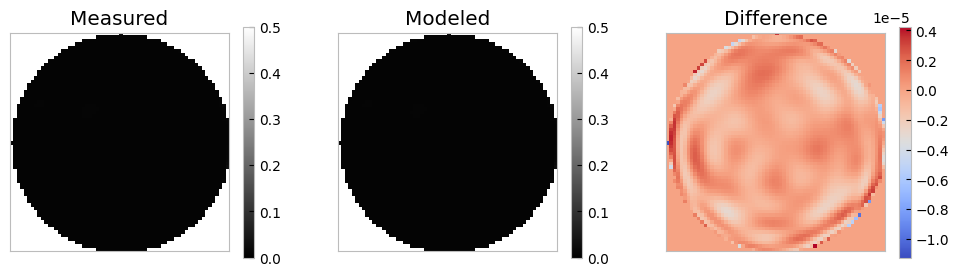

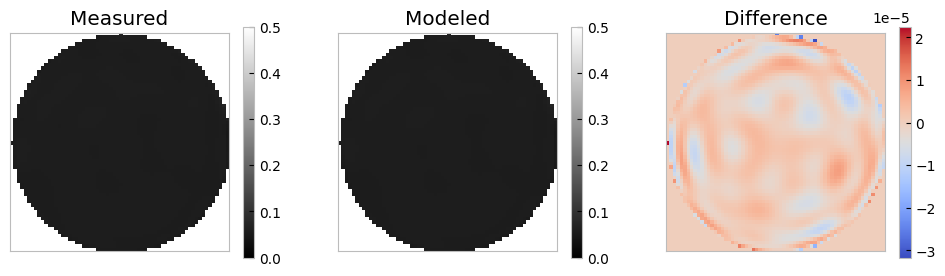

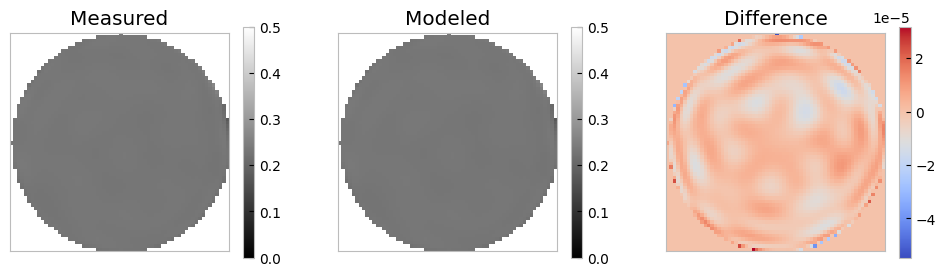

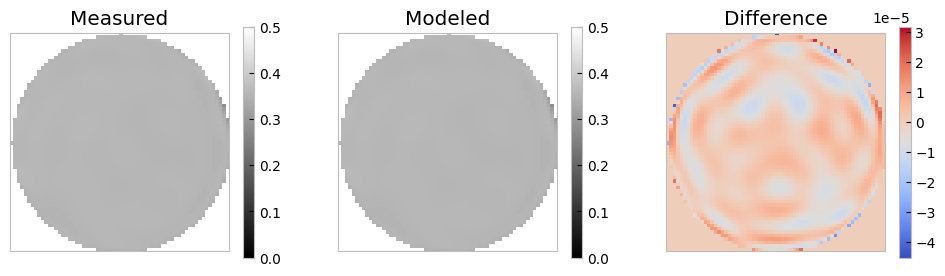

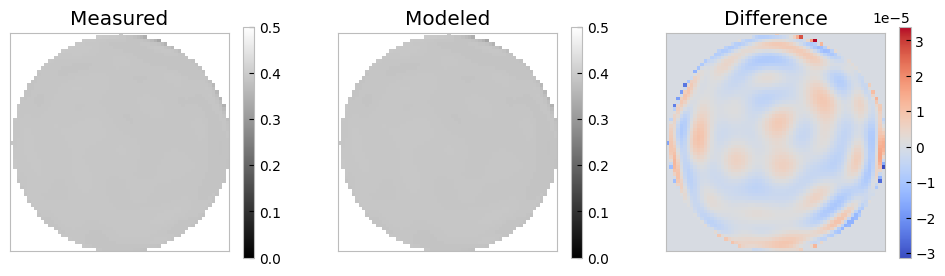

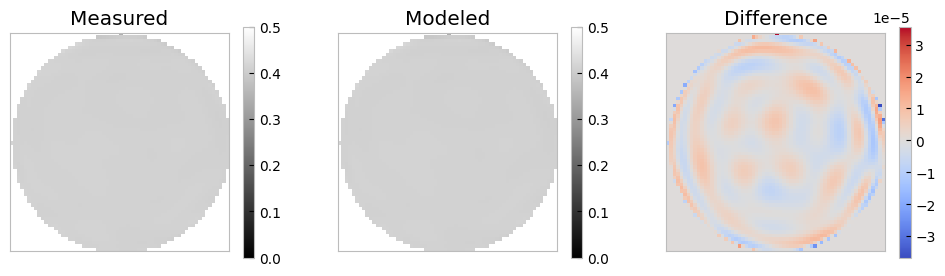

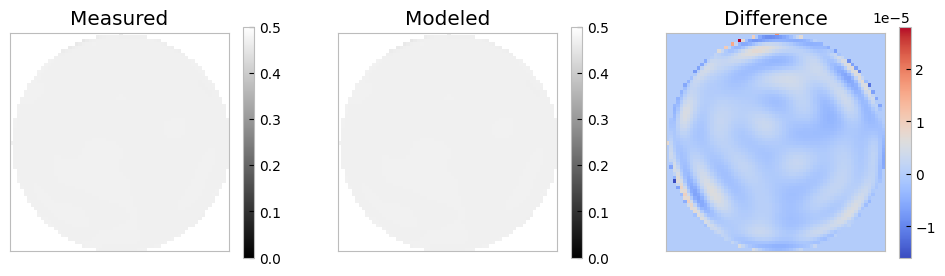

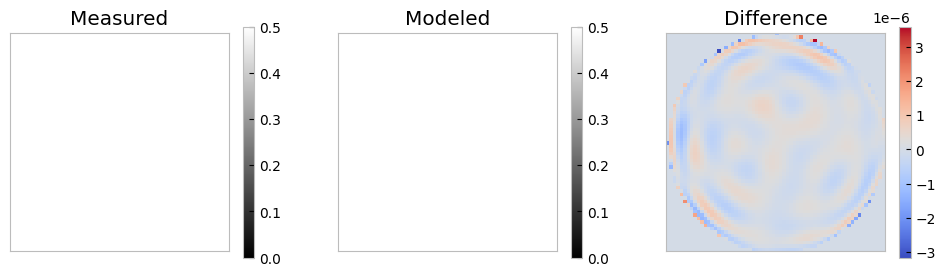

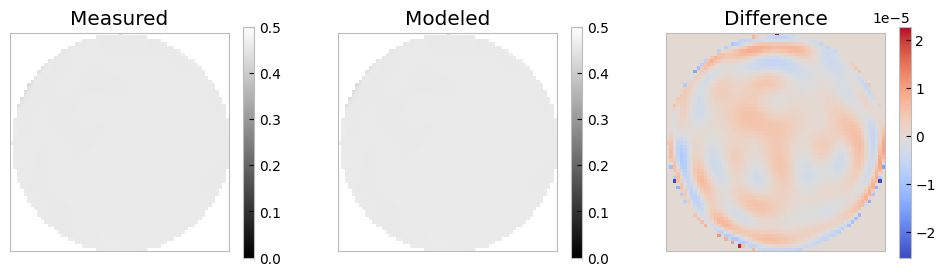

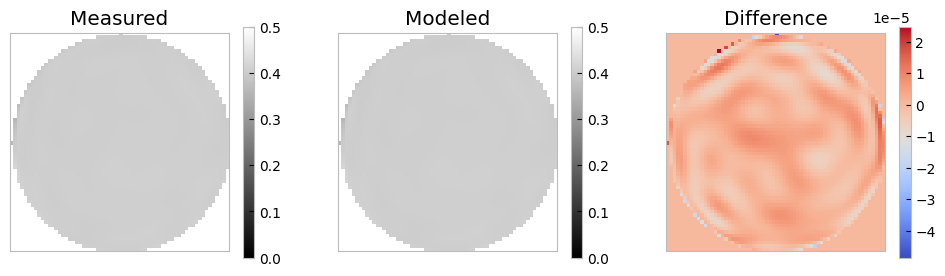

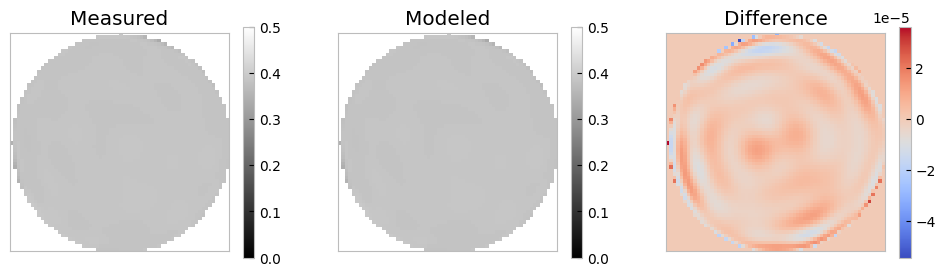

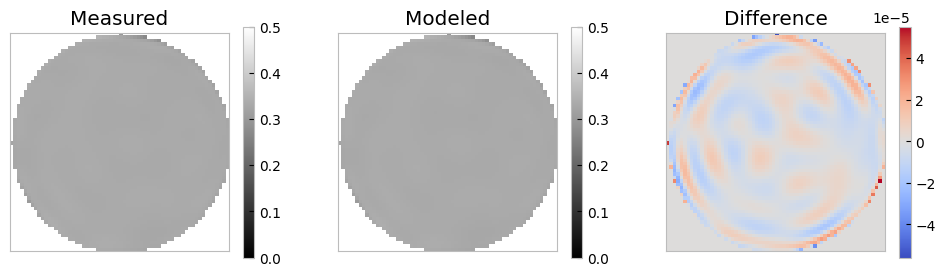

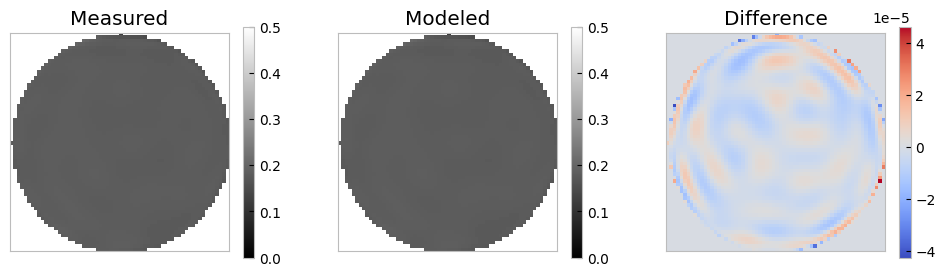

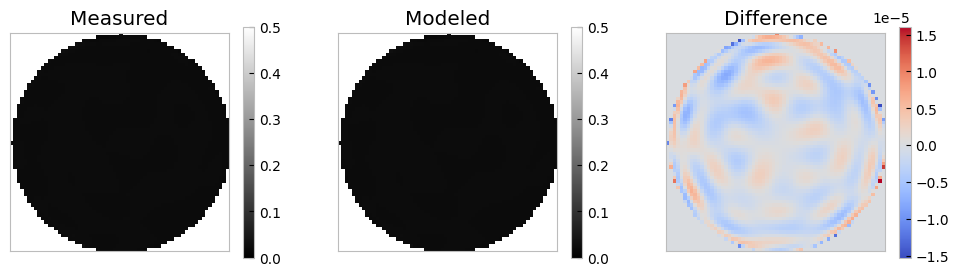

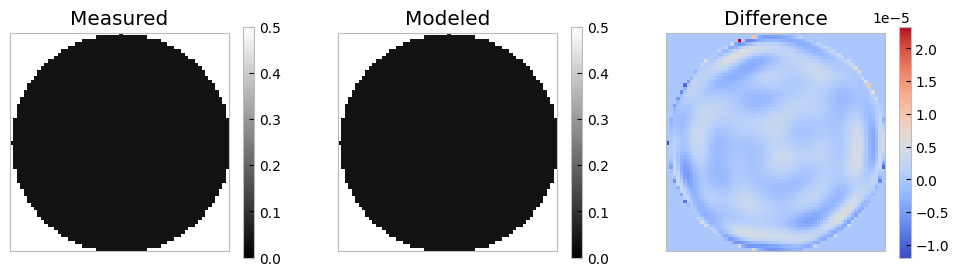

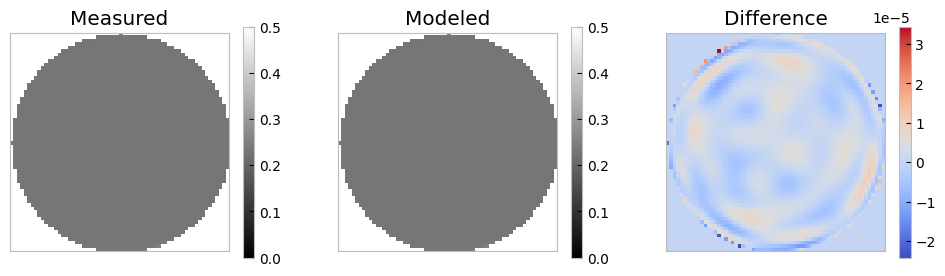

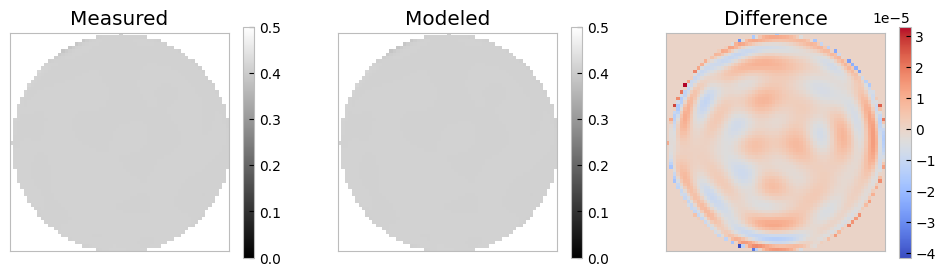

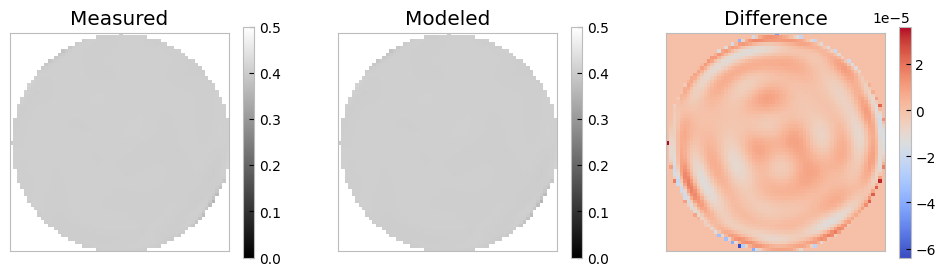

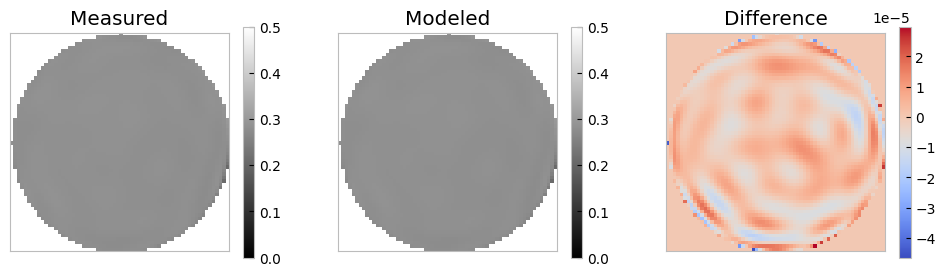

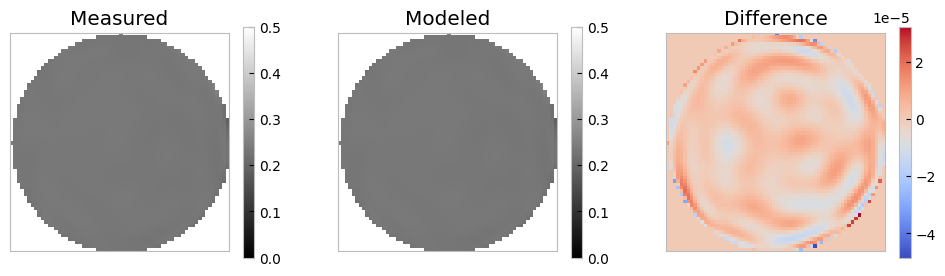

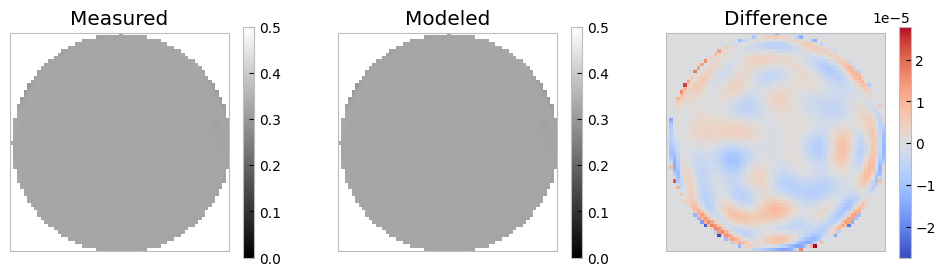

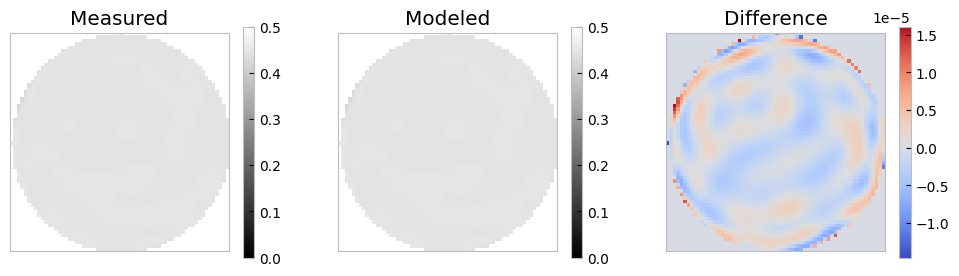

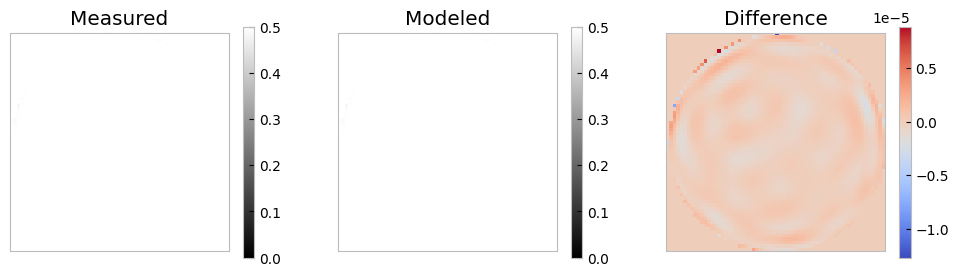

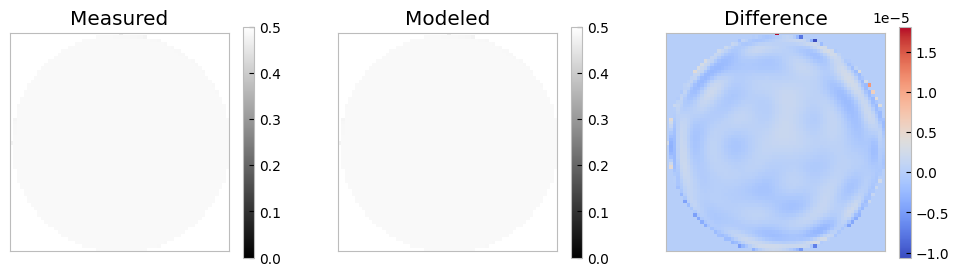

In [19]:
power_modeled = forward_simulate(results_jax.x)

for i in range(NMEAS):

    pe = power_experiment[..., i]
    pm = power_modeled[..., i]

    plt.figure(figsize=[12,3])
    plt.subplot(131)
    plt.imshow(pe, cmap="gray", vmin=0, vmax=0.5)
    plt.colorbar()
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title("Measured")
    plt.subplot(132)
    plt.imshow(pm, cmap="gray", vmin=0, vmax=0.5)
    plt.colorbar()
    plt.title("Modeled")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.subplot(133)
    plt.imshow(pm - pe, cmap="coolwarm")
    plt.colorbar()
    plt.title("Difference")
    plt.xticks([],[])
    plt.yticks([],[])
    plt.show()

In [17]:
print("Finite Differences Squared Error = ", results.fun)
print("Autodiff Squared Error = ", results_jax.fun)

Finite Differences Squared Error =  0.047364743193699536
Autodiff Squared Error =  0.04736477834700421


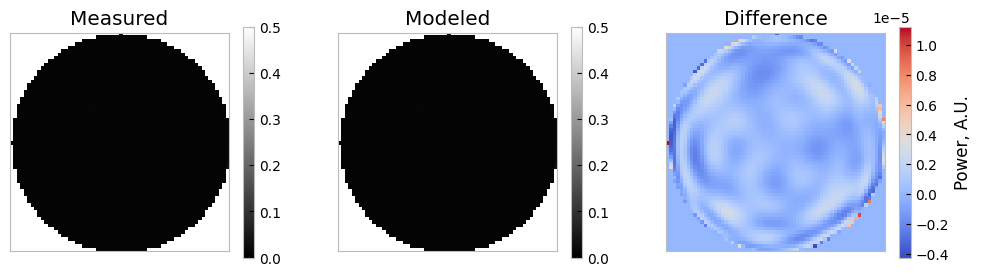

In [20]:
pe = power_experiment[..., 0]
pm = power_modeled[..., 0]

fig = plt.figure(figsize=[12,3])
plt.subplot(131)
im1 = plt.imshow(pe, cmap="gray", vmin=0, vmax=0.5)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.title("Measured")
plt.subplot(132)
im2 = plt.imshow(pm, cmap="gray", vmin=0, vmax=0.5)
plt.colorbar()
plt.title("Modeled")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(133)
im3 = plt.imshow(pe - pm, cmap="coolwarm")
plt.colorbar(label="Power, A.U.")
plt.title("Difference")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

def update(i):

    pe = power_experiment[..., i]
    pm = power_modeled[..., i]
    diff = pe - pm

    im1.set_data(pe)
    im2.set_data(pm)
    im3.set_data(diff)

    return [im1, im2, im3]

ani = FuncAnimation(fig, update, frames=range(NMEAS), blit=True, interval=1)



In [21]:
# ani.save("jaxd_spatial_calibration_N100.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


So as we knew, this method lets us fit to the universe. While we aren't doing it here, one can imagine a variant of this technique where power measurements are taken after rotating the PSG and PSA in sequence. In other words, one would include a frame after rotating the PSG, and then another frame after rotating the PSA. 

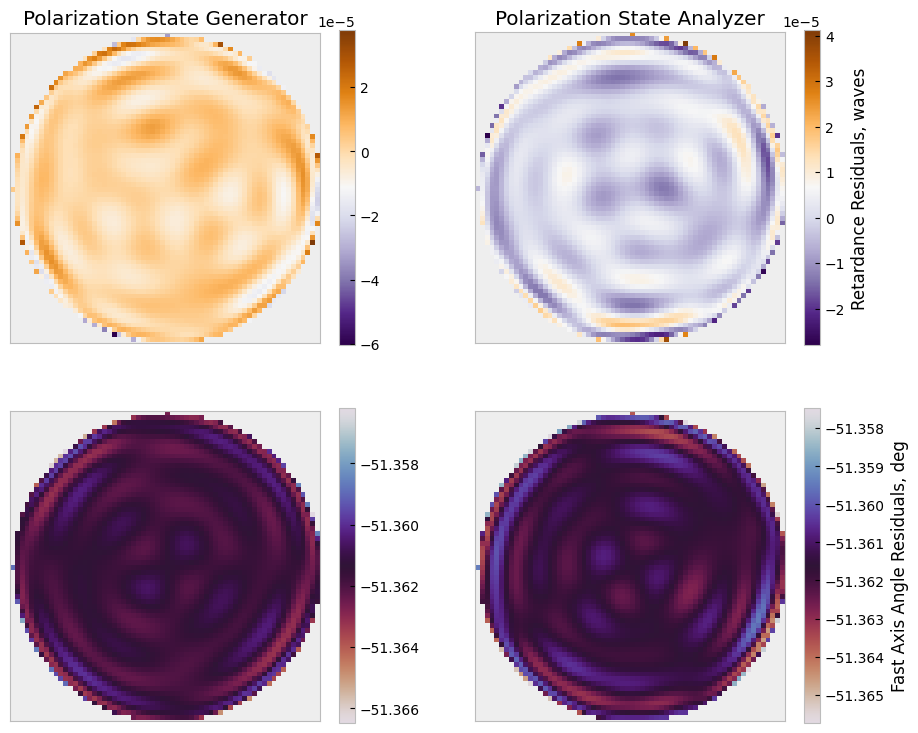

In [28]:
# Did we actually re-create the retardance / fast axis?

# extract the coefficients
modeled_coeffs_spatial_ret_psg = results_jax.x[2 : 2 + 1*len(basis)]
modeled_coeffs_spatial_ang_psg = results_jax.x[2 + 1*len(basis):(2 + 2*len(basis))]
modeled_coeffs_spatial_ret_psa = results_jax.x[2 + 2*len(basis):(2 + 3*len(basis))]
modeled_coeffs_spatial_ang_psa = results_jax.x[2 + 3*len(basis):(2 + 4*len(basis))]


retardance_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psg)
retardance_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psa)
angle_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psg)
angle_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psa)

plt.figure(figsize=[11,9])
plt.subplot(221)
plt.title("Polarization State Generator")
plt.imshow((retardance_psg_modeled - retardance_psg) / (2 * np.pi) / A, cmap="PuOr_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(222)
plt.title("Polarization State Analyzer")
plt.imshow((retardance_psa_modeled - retardance_psa) / (2 * np.pi) / A, cmap="PuOr_r")
plt.colorbar(label="Retardance Residuals, waves")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(223)
plt.imshow(np.degrees(angle_psg_modeled - angle_psg) / A, cmap="twilight_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(224)
plt.imshow(np.degrees(angle_psa_modeled - angle_psa) / A, cmap="twilight_r")
plt.colorbar(label="Fast Axis Angle Residuals, deg")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

The constant angular offset has to do with air measurements being invariant under rotation, so the fact that the PSG and PSA are off by the same constant means that we optimized them to 1/100th of a degree. Not too shabby. Next up is to try this again (just using the AD'd calibration routine) subject to noisy frames

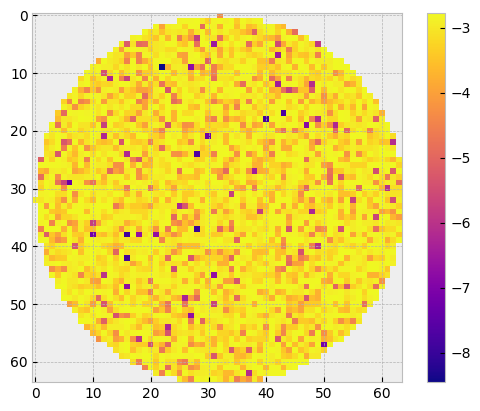

In [201]:
# how do we add photon noise to a frame? Gotta discretise I guess
test_frame = power_experiment[..., 5]

test_frame_nphotons = (100 * test_frame)
test_frame_noisy = poisson.logpmf(k=tnp.random.poisson(test_frame_nphotons), mu=test_frame_nphotons)
plt.imshow(test_frame_noisy / A, cmap="plasma")
plt.colorbar()

/var/folders/83/ytrwsp9n3c3cly8tf8v6h03h0000gp/T/ipykernel_90364/2242075565.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(test_frame_nphotons / A, cmap="gray", vmax=43, vmin=40)


([], [])

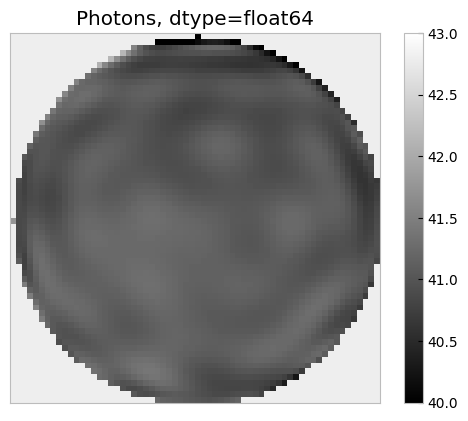

In [197]:
plt.title(f"Photons, dtype={test_frame_nphotons.dtype}")
plt.imshow(test_frame_nphotons / A, cmap="gray", vmax=43, vmin=40)
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])

Encountering an issue with jax's poisson.logpmf. Looks like you need integer values to go into the logpmf, but can't propagate a gradient through it. Alas

In [244]:
N_PHOTONS = 1000

# define the maximum likelihood estimator
from scipy.stats import poisson as poisson_sp
from jax.scipy.stats import poisson, norm
from jax import jacrev
from jax import random

key = random.key(43)

# Make the photon noisy images
noisy_power_experiment = []
for i in range(NMEAS):
    binned_img = random.poisson(key, lam=N_PHOTONS * power_experiment[..., i])
    binned_int = binned_img
    noisy_power_experiment.append(binned_int)


# recall which value goes where, I think it's the following?
# poisson.logpmf(k=value_measured, mu=value_modeled)
# this returns infinite values so I suspect not, let's flip it lol

def log_likelihood(x):

    # simulate the power
    power_simulate = (forward_simulate(x) * N_PHOTONS)
    loglike = poisson.logpmf(k=noisy_power_experiment[0],
                                        mu=power_simulate[..., 0])

    for i in range(1, NMEAS):

        loglike = loglike + poisson.logpmf(k=noisy_power_experiment[i],
                                            mu=power_simulate[..., i])
            
        return -np.sum(np.asarray(loglike)[A==1])

loglike_fg = value_and_grad(log_likelihood)
loglike_fg(x0)

(Array(1038361.87631322, dtype=float64),
 Array([-2.52507593e+06, -2.45165880e+06, -2.69262947e+04, -2.40821682e+00,
        -7.57858873e+00,  7.61755411e+01, -9.86616733e-01, -6.03726898e-01,
         5.81420413e+00,  1.69651889e+01, -1.06589847e+01,  1.21940925e+01,
         7.45672109e+01,  3.50594128e+00,  1.99810859e+00,  9.69006599e+01,
         6.77460504e+01,  1.04628946e+01,  4.34221140e+00,  1.23590960e+01,
        -3.94003579e+00,  1.86862843e+00,  9.45127778e+00,  7.31453967e+01,
        -9.31274447e+00, -1.87179130e+00,  6.14798628e+01,  9.77025852e+01,
        -5.04846721e+00,  4.28124384e+00,  5.64063823e+00,  8.29316688e+00,
        -1.47533426e+00,  8.80768608e+00,  1.25944523e+01, -4.20836883e+00,
         1.40369349e+00,  6.31081210e+00,  6.90964342e+01, -1.11030948e+00,
        -6.92362207e+00,  8.90810460e+01,  5.53656605e+01, -6.04058122e+00,
        -1.61975505e+00,  3.94264329e+01,  7.70732913e+01,  5.23325248e+00,
         1.05563637e+01,  1.00442379e+01, -8.33

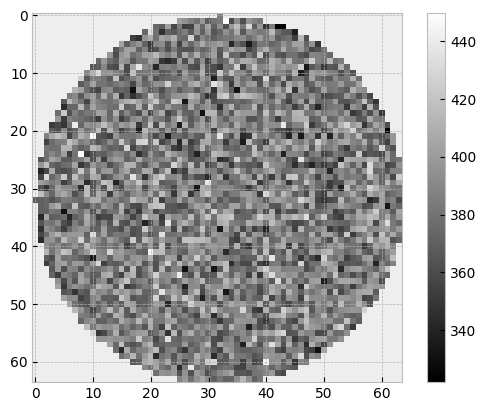

In [245]:
plt.imshow(noisy_power_experiment[10] / A,cmap="gray")
plt.colorbar()

In [246]:
MAX_ITERS = 100

with tqdm(total=MAX_ITERS) as pbar:
    results_jax = minimize(loglike_fg, x0=x0, callback=callback, method="L-BFGS-B", jac=True,
                       options={"maxiter": MAX_ITERS})

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


In [247]:
print(results_jax)

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 18912.16230685851
        x: [ 3.887e-01  9.589e-01 ...  2.310e-04  1.682e-03]
      nit: 100
      jac: [ 2.514e+02  2.241e+02 ...  5.268e+01 -1.562e+02]
     nfev: 113
     njev: 113
 hess_inv: <510x510 LbfgsInvHessProduct with dtype=float64>


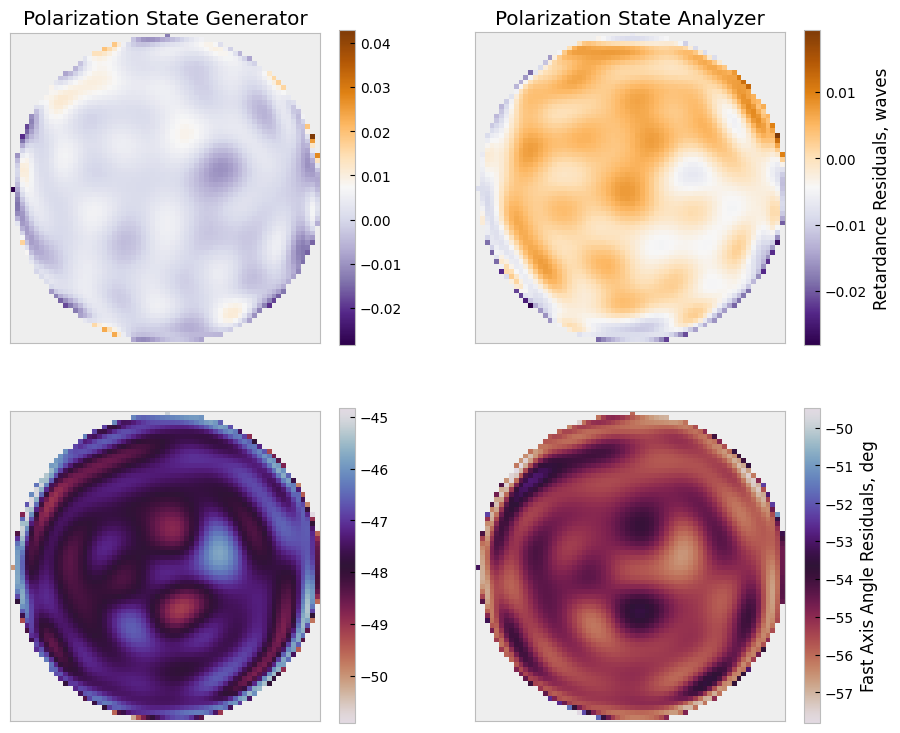

In [249]:
# Did we actually re-create the retardance / fast axis?

# extract the coefficients
modeled_coeffs_spatial_ret_psg = results_jax.x[2 : 2 + 1*len(basis)]
modeled_coeffs_spatial_ang_psg = results_jax.x[2 + 1*len(basis):(2 + 2*len(basis))]
modeled_coeffs_spatial_ret_psa = results_jax.x[2 + 2*len(basis):(2 + 3*len(basis))]
modeled_coeffs_spatial_ang_psa = results_jax.x[2 + 3*len(basis):(2 + 4*len(basis))]


retardance_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psg)
retardance_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ret_psa)
angle_psg_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psg)
angle_psa_modeled = sum_of_2d_modes_wrapper(basis, modeled_coeffs_spatial_ang_psa)

plt.figure(figsize=[11,9])
plt.subplot(221)
plt.title("Polarization State Generator")
plt.imshow((retardance_psg_modeled - retardance_psg) / (2 * np.pi) / A, cmap="PuOr_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(222)
plt.title("Polarization State Analyzer")
plt.imshow((retardance_psa_modeled - retardance_psa) / (2 * np.pi) / A, cmap="PuOr_r")
plt.colorbar(label="Retardance Residuals, waves")
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(223)
plt.imshow(np.degrees(angle_psg_modeled - angle_psg) / A, cmap="twilight_r")
plt.colorbar()
plt.xticks([],[])
plt.yticks([],[])
plt.subplot(224)
plt.imshow(np.degrees(angle_psa_modeled - angle_psa) / A, cmap="twilight_r")
plt.colorbar(label="Fast Axis Angle Residuals, deg")
plt.xticks([],[])
plt.yticks([],[])
plt.show()

In [250]:
from jax import hessian
fim = hessian(log_likelihood)

In [252]:
FIM = fim(results_jax.x)

: 